In [5]:
import os
import json
from PIL import Image
import torch
from torchvision import transforms
import torch
from transformers import BertModel, BertTokenizer
import clip
from PIL import Image
image_folder = 'C:\\Users\\wjw\\Desktop\\111\\hateful_memes\\img\\'  # 图像文件夹路径
json_file = 'test_seen.jsonl'  # JSON文件路径列表
# 存储所有图像、文本和标签
images = []
texts = []
labels = []
image_paths = []
Id=[]
# 遍历每个JSON文件
with open(json_file, 'r') as f:
        data = [json.loads(line) for line in f]
        for entry in data:
            img_name = entry['img']  # 获取图像路径
            img_path = img_name.replace('img/','img//')
            iid=img_name.replace('png','').replace('img/','')
            if os.path.isfile(img_path):
                try:
                    img = Image.open(img_path).convert('RGB')  # 确保图像为RGB格式
                    images.append(img)
                    texts.append(entry['text'])                # 存储对应文本
                    labels.append(entry['label'])               # 存储标签
                    image_paths.append(img_path)
                    Id.append(iid)
                except Exception as e:
                    print(f'Error loading image {img_path}: {e}')

In [21]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# 加载预训练的GPT-2模型和分词器
model_name = "gpt2"  # 可以选择其他版本，如 "gpt2-medium", "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, output_hidden_states=True)

C:\Users\wjw\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [40]:
tokenizer.pad_token = tokenizer.eos_token
model.eval()

def extract_multiple_sentences_features(sentences):
    # 对输入句子进行编码
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)

    # 获取模型输出
    with torch.no_grad():
        outputs = model(**inputs)

    # 提取所有句子的所有token的输出特征
    all_token_features = outputs.hidden_states[-1]  # 获取最后一层的特征
    return all_token_features

In [41]:
features = extract_multiple_sentences_features(texts)
print(features)

tensor([[[-1.6570e-01, -3.3441e-02, -4.0684e-01,  ..., -1.4391e-01,
          -9.8404e-02, -1.2951e-01],
         [ 4.2574e-01,  2.8238e-01, -3.4555e-01,  ..., -3.5093e-02,
           3.2919e-01, -7.0788e-02],
         [ 1.8971e-01,  1.2643e-01, -8.9694e-01,  ..., -2.8374e-01,
          -3.7694e-02,  3.4366e-01],
         ...,
         [-4.9807e-02, -2.9277e-02, -1.8086e-01,  ..., -3.8818e-02,
          -1.6040e-01, -1.6318e-01],
         [-5.2516e-02, -2.8882e-02, -1.8062e-01,  ..., -4.0286e-02,
          -1.6256e-01, -1.6366e-01],
         [-5.1001e-02, -2.9140e-02, -1.8065e-01,  ..., -3.8910e-02,
          -1.6126e-01, -1.6248e-01]],

        [[-7.9017e-02, -6.3947e-02, -4.1511e-01,  ..., -1.7915e-01,
          -7.7898e-02, -1.7414e-01],
         [-3.8564e-01, -3.6903e-01, -3.8428e-01,  ...,  2.4232e-01,
           5.1427e-01,  2.1826e-02],
         [-3.0841e-01, -1.0032e+00,  1.6015e-01,  ..., -1.3930e-01,
           1.1741e-01, -4.6991e-01],
         ...,
         [ 2.0465e-02, -1

In [42]:
features.shape

torch.Size([815, 78, 768])

In [43]:
import torch
from torchvision import transforms
from transformers import AutoFeatureExtractor, AutoModel
from transformers import ViTModel, ViTFeatureExtractor

feature_extractor1 = ViTFeatureExtractor.from_pretrained("WinKawaks/vit-small-patch16-224")
model1 = ViTModel.from_pretrained("WinKawaks/vit-small-patch16-224")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs1 = feature_extractor1(images=images, return_tensors="pt")
model1.to(device)
model1.eval()
with torch.no_grad():
   outputs1 = model1(**inputs1)
   last_hidden_state1 = outputs1.last_hidden_state
print(last_hidden_state1.shape)# 获取特征表示

C:\Users\wjw\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([815, 197, 384])


In [45]:
x=last_hidden_state1.reshape(last_hidden_state1.size(0), -1)
x1=features.reshape(features.size(0), -1)

In [46]:
import torch
import torch.nn as nn

class MultipleLinearTransform(nn.Module):
    def __init__(self, input_dim, num_transforms):
        super(MultipleLinearTransform, self).__init__()
        # 定义线性层
        self.linear = nn.Linear(input_dim, input_dim)
        # 定义变换的次数
        self.num_transforms = num_transforms

    def forward(self, x):
        # 初始化累加结果
        total_result = torch.zeros_like(x)
        current_input = x
        for _ in range(self.num_transforms):
            # 进行线性变换
            transformed = self.linear(current_input)
            # 累加结果
            total_result += transformed
            # 更新当前输入
            current_input = transformed
        return total_result


class DualNetwork(nn.Module):
    def __init__(self, features_dim1, features_dim2, inflect_dim, num_transforms):
        super(DualNetwork, self).__init__()
        # 定义两个单层网络
        self.model1 = nn.Linear(features_dim1, inflect_dim)  # 第一个网络
        self.model2 = nn.Linear(features_dim2, inflect_dim)  # 第二个网络
        self.transform = MultipleLinearTransform(inflect_dim, num_transforms)

    def forward(self, x1, x2):
        # 前向传播
        output1 = self.model1(x1)
        output2 = self.model2(x2)

        # 使用 MultipleLinearTransform 进行多次线性变换并求和
        sum_result1 = self.transform(output1)
        sum_result2 = self.transform(output2)

        # 标准化输出
        standardized_output1 = self.standardize(sum_result1)
        standardized_output2 = self.standardize(sum_result2)

        # 计算标准化后的点积
        dot_product = torch.matmul(standardized_output1, standardized_output2.T)
        return dot_product,sum_result1,sum_result2

    def standardize(self, tensor):
        # 标准化函数
        mean = tensor.mean(dim=0, keepdim=True)
        std = tensor.std(dim=0, keepdim=True)
        std = torch.clamp(std, min=1e-8)  # 避免除零错误
        return (tensor - mean) / std

In [47]:
model = DualNetwork(x.shape[1], x1.shape[1],512,len(x))

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)
criterion = nn.CrossEntropyLoss()
euclidean_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
label=np.arange(x.shape[0])
label = torch.from_numpy(label)
losses = []
cosine_loss=[]
distance_loss=[]
# 训练示例
for epoch in range(50):  # 假设训练100个epoch
    optimizer.zero_grad()  # 清除上一步的梯度
    output = model(x,x1)
    euclidean_distance_loss = euclidean_loss(output[1], output[2])
    loss = criterion(output[0], label)
    total_loss =0.5 * loss + 0.5 * euclidean_distance_loss# 计算交叉熵损失
    total_loss.backward()  # 反向传播
    optimizer.step()
    losses.append(total_loss.item())
    cosine_loss.append(loss.item())
    distance_loss.append(euclidean_distance_loss.item())# 更新参数
    #if epoch % 10 == 0:  # 每10个epoch打印一次损失
    print(f'Epoch [{epoch}], Loss: {total_loss.item():.4f}')
print("模型参数：")
for param in model.parameters():
    print(param)

Epoch [0], Loss: 95.5725
Epoch [1], Loss: 1349.1626
Epoch [2], Loss: 2286.5647
Epoch [3], Loss: 1461.4725
Epoch [4], Loss: 1037.3721
Epoch [5], Loss: 849.5021
Epoch [6], Loss: 682.6328
Epoch [7], Loss: 592.4738
Epoch [8], Loss: 507.2868
Epoch [9], Loss: 435.2450
Epoch [10], Loss: 385.4579
Epoch [11], Loss: 357.6116
Epoch [12], Loss: 328.6990
Epoch [13], Loss: 290.2959
Epoch [14], Loss: 254.3481
Epoch [15], Loss: 227.6078
Epoch [16], Loss: 202.6758
Epoch [17], Loss: 179.3387
Epoch [18], Loss: 159.3180
Epoch [19], Loss: 142.6585
Epoch [20], Loss: 129.4626
Epoch [21], Loss: 117.7906
Epoch [22], Loss: 107.1347
Epoch [23], Loss: 98.4943
Epoch [24], Loss: 90.2870
Epoch [25], Loss: 82.4441
Epoch [26], Loss: 75.9900
Epoch [27], Loss: 70.3624
Epoch [28], Loss: 64.8132
Epoch [29], Loss: 59.3266
Epoch [30], Loss: 54.6224
Epoch [31], Loss: 50.7579
Epoch [32], Loss: 46.9376
Epoch [33], Loss: 43.3151
Epoch [34], Loss: 40.4007
Epoch [35], Loss: 37.9477
Epoch [36], Loss: 35.4122
Epoch [37], Loss: 32.7

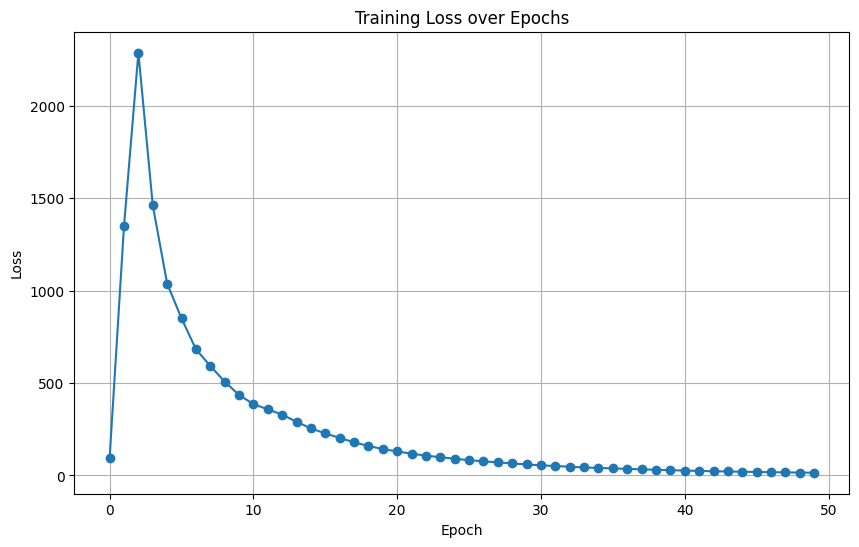

In [49]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(50), losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [50]:
x_combine=torch.cat((output[1], output[2]), dim=1)
features_np = x_combine.detach().numpy()
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(features_np, labels, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [2]:
import torch
import torch.nn as nn

class BinaryClassifier(nn.Module):
     def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # 第一个全连接层
        self.fc2 = nn.Linear(128, 64)           # 第二个全连接层
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)# 输出层
        self.relu = nn.ReLU()                   # ReLU 激活函数
        self.sigmoid = nn.Sigmoid()             # Sigmoid 激活函数用于二分类

     def forward(self, x):
        x = self.relu(self.fc1(x))              # 第一层
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))           # 输出层
        return x                                 # 返回概率值

# 使用示例
input_size = 1024  # 输入特征的维度
model = BinaryClassifier(input_size)

# 打印模型结构
print(model)

BinaryClassifier(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
acc=[]
set_seed(42)
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    optimizer.zero_grad()
    
    # 前向传播
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1).float())
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    model.eval()  # 设置为评估模式
    with torch.no_grad():  # 不计算梯度
        val_outputs = model(X_val)  # 在验证集上进行前向传播
        val_predicted = (val_outputs >= 0.5).float()  # 将输出转换为0或1的预测
        correct_predictions = (val_predicted.view(-1) == y_val).sum().item()  # 计算正确预测的数量
        val_accuracy = correct_predictions / y_val.size(0)  # 计算验证集的准确率
        acc.append(val_accuracy)
    #if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

NameError: name 'set_seed' is not defined

In [53]:
import pandas as pd
loss_df = pd.DataFrame({
    "Loss1": cosine_loss,
    "Loss2": distance_loss,
    "TotalLoss": losses
})
loss_df.to_csv("loss_values_3.csv", index=False)

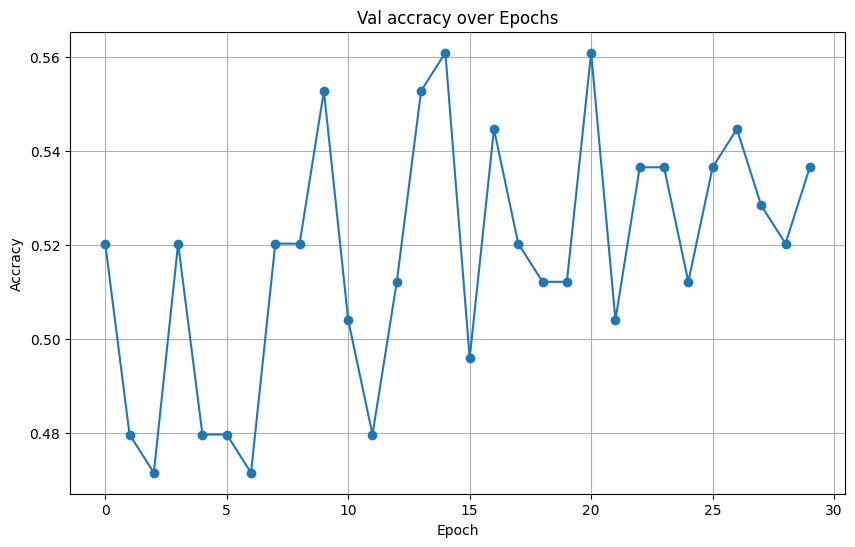

In [54]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(30), acc, marker='o')
plt.title('Val accracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accracy')
plt.grid(True)
plt.show()

In [55]:
from sklearn.metrics import f1_score
with torch.no_grad():
    val_outputs = model(X_val)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_val).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_val_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 53.66%
Validation F1 Score: 0.4571


In [56]:
with torch.no_grad():
    val_outputs = model(X_test)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_test).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_test_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 50.00%
Validation F1 Score: 0.3377


In [57]:
import torch

def add_gaussian_noise_pytorch(features, mean=0, std=0.1):
    """
    给 PyTorch 张量形式的特征添加高斯噪声
    :param features: 处理好的特征张量
    :param mean: 高斯噪声的均值
    :param std: 高斯噪声的标准差
    :return: 添加噪声后的特征张量
    """
    # 生成与特征张量形状相同的高斯噪声
    noise = torch.randn(features.size()) * std + mean
    # 将噪声添加到特征上
    noisy_features = features + noise
    return noisy_features
# 添加高斯噪声
X_test_noise = add_gaussian_noise_pytorch(X_test, mean=0, std=0.1)
y_test_noise=y_test+y_test
print("Original features shape:", X_test_noise.shape)
print("Noisy features shape:", y_test_noise.shape)

Original features shape: torch.Size([204, 1024])
Noisy features shape: torch.Size([204])


In [58]:
from sklearn.metrics import f1_score
model.eval()  # 设置为评估模式
with torch.no_grad():
    val_outputs = model(X_test_noise)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_test_noise).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_test_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 37.25%
Validation F1 Score: 0.3377


In [59]:
X_val_noise = add_gaussian_noise_pytorch(X_val, mean=0, std=0.1)
y_val_noise=y_val+y_val
from sklearn.metrics import f1_score
model.eval()  # 设置为评估模式
with torch.no_grad():
    val_outputs = model(X_val_noise)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_val_noise).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_val_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 34.15%
Validation F1 Score: 0.4571


In [60]:
import torch
import numpy as np

def add_salt_and_pepper_noise(features, salt_prob=0.01, pepper_prob=0.01):
    """
    给 PyTorch 张量形式的特征添加椒盐噪声
    :param features: 处理好的特征张量
    :param salt_prob: 添加盐噪声的概率
    :param pepper_prob: 添加胡椒噪声的概率
    :return: 添加噪声后的特征张量
    """
    # 创建一个与特征相同形状的噪声张量
    noisy_features = features.clone()
    
    # 生成随机数
    random_values = torch.rand(features.size())
    
    # 添加盐噪声（随机选择一些像素点设置为最大值）
    noisy_features[random_values < salt_prob] = 1.0  # 1.0 表示盐噪声
    
    # 添加胡椒噪声（随机选择一些像素点设置为最小值）
    noisy_features[random_values > (1 - pepper_prob)] = 0.0  # 0.0 表示胡椒噪声
    
    return noisy_features

# 添加椒盐噪声
X_test_noise = add_salt_and_pepper_noise(X_test, salt_prob=0.01, pepper_prob=0.01)
y_test_noise = y_test + y_test  # 根据需要进行修改
print("Original features shape:", X_test.shape)
print("Noisy features shape:", X_test_noise.shape)

Original features shape: torch.Size([204, 1024])
Noisy features shape: torch.Size([204, 1024])


In [61]:
from sklearn.metrics import f1_score
model.eval()  # 设置为评估模式
with torch.no_grad():
    val_outputs = model(X_test_noise)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_test_noise).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_test_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 38.24%
Validation F1 Score: 0.3529


In [62]:
X_val_noise = add_salt_and_pepper_noise(X_val, salt_prob=0.01, pepper_prob=0.01)
y_val_noise=y_val+y_val
from sklearn.metrics import f1_score
model.eval()  # 设置为评估模式
with torch.no_grad():
    val_outputs = model(X_val_noise)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_val_noise).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_val_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 33.33%
Validation F1 Score: 0.4078


In [63]:
import torch.nn as nn

class FeatureMapper(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeatureMapper, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

In [64]:
def attention(query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1))  # 点积
        weights = nn.functional.softmax(scores, dim=-1)  # softmax
        return torch.matmul(weights, value)  # 加权求和

In [65]:
def fusion(original, attended):
        return original + attended  # 或者使用 torch.cat 进行连接

In [67]:
x1.shape

torch.Size([815, 59904])

In [68]:
image_mapper = FeatureMapper(75648, 512)
text_mapper = FeatureMapper(59904, 512)

mapped_image = image_mapper(x)
mapped_text = text_mapper(x1)

# 计算注意力
attended_image = attention(mapped_text, mapped_image, mapped_image)
attended_text = attention(mapped_image, mapped_text, mapped_text)

# 特征融合
fused_image = fusion(mapped_image, attended_image)
fused_text = fusion(mapped_text, attended_text)

In [69]:
x_fuse=torch.cat((fused_image, fused_text), dim=1)
x_fuse = x_fuse.detach().numpy()
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(x_fuse, labels, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [70]:
import torch
import torch.nn as nn

class BinaryClassifier(nn.Module):
     def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # 第一个全连接层
        self.fc2 = nn.Linear(128, 64)           # 第二个全连接层
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)# 输出层
        self.relu = nn.ReLU()                   # ReLU 激活函数
        self.sigmoid = nn.Sigmoid()             # Sigmoid 激活函数用于二分类

     def forward(self, x):
        x = self.relu(self.fc1(x))              # 第一层
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))           # 输出层
        return x                                 # 返回概率值

# 使用示例
input_size = 1024  # 输入特征的维度
model = BinaryClassifier(input_size)

# 打印模型结构
print(model)

BinaryClassifier(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [71]:
import numpy as np
import random
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
acc1=[]
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    optimizer.zero_grad()
    
    # 前向传播
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1).float())
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    model.eval()  # 设置为评估模式
    with torch.no_grad():  # 不计算梯度
        val_outputs = model(X_val)  # 在验证集上进行前向传播
        val_predicted = (val_outputs >= 0.5).float()  # 将输出转换为0或1的预测
        correct_predictions = (val_predicted.view(-1) == y_val).sum().item()  # 计算正确预测的数量
        val_accuracy = correct_predictions / y_val.size(0)  # 计算验证集的准确率
        acc1.append(val_accuracy)
    #if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/30], Loss: 0.6967, Val Accuracy: 0.4797
Epoch [2/30], Loss: 0.7022, Val Accuracy: 0.5203
Epoch [3/30], Loss: 0.6954, Val Accuracy: 0.5610
Epoch [4/30], Loss: 0.6903, Val Accuracy: 0.4797
Epoch [5/30], Loss: 0.6901, Val Accuracy: 0.4715
Epoch [6/30], Loss: 0.6875, Val Accuracy: 0.5203
Epoch [7/30], Loss: 0.6853, Val Accuracy: 0.5285
Epoch [8/30], Loss: 0.6841, Val Accuracy: 0.5366
Epoch [9/30], Loss: 0.6814, Val Accuracy: 0.5447
Epoch [10/30], Loss: 0.6800, Val Accuracy: 0.5447
Epoch [11/30], Loss: 0.6770, Val Accuracy: 0.5366
Epoch [12/30], Loss: 0.6754, Val Accuracy: 0.5447
Epoch [13/30], Loss: 0.6723, Val Accuracy: 0.5691
Epoch [14/30], Loss: 0.6702, Val Accuracy: 0.5447
Epoch [15/30], Loss: 0.6670, Val Accuracy: 0.5366
Epoch [16/30], Loss: 0.6639, Val Accuracy: 0.5691
Epoch [17/30], Loss: 0.6608, Val Accuracy: 0.5447
Epoch [18/30], Loss: 0.6567, Val Accuracy: 0.5691
Epoch [19/30], Loss: 0.6520, Val Accuracy: 0.5610
Epoch [20/30], Loss: 0.6468, Val Accuracy: 0.5610
Epoch [21

In [72]:
from sklearn.metrics import f1_score
with torch.no_grad():
    val_outputs = model(X_val)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_val).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_val_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 50.41%
Validation F1 Score: 0.4078


In [73]:
with torch.no_grad():
    val_outputs = model(X_test)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_test).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_test_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 54.90%
Validation F1 Score: 0.3521


In [74]:
import torch
import torch.nn as nn

class FeatureFusion(nn.Module):
    def __init__(self, input_dim_u1, input_dim_u2):
        super(FeatureFusion, self).__init__()
        # 定义线性层以调整特征维度
        self.linear_u1 = nn.Linear(input_dim_u1, 512)
        self.linear_u2 = nn.Linear(input_dim_u2, 512)

    def forward(self, u1, u2):
        # 调整特征维度
        u1_transformed = self.linear_u1(u1)
        u2_transformed = self.linear_u2(u2)

        # 计算外积
        # 相加
        z = u1_transformed + u2_transformed
        return z

# 示例输入
feature_dim_u1 = 75648  # 模态1特征维度
feature_dim_u2 = 59904  # 模态2特征维度
feature_fusion = FeatureFusion(feature_dim_u1, feature_dim_u2)

# 计算融合特征
z = feature_fusion(x, x1)

In [75]:
import torch
import torch.nn as nn

class BinaryClassifier(nn.Module):
     def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # 第一个全连接层
        self.fc2 = nn.Linear(128, 64)           # 第二个全连接层
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)# 输出层
        self.relu = nn.ReLU()                   # ReLU 激活函数
        self.sigmoid = nn.Sigmoid()             # Sigmoid 激活函数用于二分类

     def forward(self, x):
        x = self.relu(self.fc1(x))              # 第一层
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))           # 输出层
        return x                                 # 返回概率值

# 使用示例
input_size = 512  # 输入特征的维度
model = BinaryClassifier(input_size)

# 打印模型结构
print(model)

BinaryClassifier(
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [76]:
z = z.detach().numpy()
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(z, labels, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [77]:
import numpy as np
import random
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
acc2=[]
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    optimizer.zero_grad()
    
    # 前向传播
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1).float())
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    model.eval()  # 设置为评估模式
    with torch.no_grad():  # 不计算梯度
        val_outputs = model(X_val)  # 在验证集上进行前向传播
        val_predicted = (val_outputs >= 0.5).float()  # 将输出转换为0或1的预测
        correct_predictions = (val_predicted.view(-1) == y_val).sum().item()  # 计算正确预测的数量
        val_accuracy = correct_predictions / y_val.size(0)  # 计算验证集的准确率
        acc2.append(val_accuracy)
    #if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/30], Loss: 0.6935, Val Accuracy: 0.4797
Epoch [2/30], Loss: 0.6918, Val Accuracy: 0.4553
Epoch [3/30], Loss: 0.6903, Val Accuracy: 0.4797
Epoch [4/30], Loss: 0.6888, Val Accuracy: 0.4715
Epoch [5/30], Loss: 0.6873, Val Accuracy: 0.4797
Epoch [6/30], Loss: 0.6855, Val Accuracy: 0.4715
Epoch [7/30], Loss: 0.6839, Val Accuracy: 0.4878
Epoch [8/30], Loss: 0.6807, Val Accuracy: 0.4634
Epoch [9/30], Loss: 0.6778, Val Accuracy: 0.5041
Epoch [10/30], Loss: 0.6755, Val Accuracy: 0.5285
Epoch [11/30], Loss: 0.6728, Val Accuracy: 0.4878
Epoch [12/30], Loss: 0.6687, Val Accuracy: 0.4878
Epoch [13/30], Loss: 0.6642, Val Accuracy: 0.5122
Epoch [14/30], Loss: 0.6613, Val Accuracy: 0.4878
Epoch [15/30], Loss: 0.6591, Val Accuracy: 0.5203
Epoch [16/30], Loss: 0.6531, Val Accuracy: 0.5122
Epoch [17/30], Loss: 0.6470, Val Accuracy: 0.4715
Epoch [18/30], Loss: 0.6449, Val Accuracy: 0.4959
Epoch [19/30], Loss: 0.6445, Val Accuracy: 0.4878
Epoch [20/30], Loss: 0.6356, Val Accuracy: 0.5041
Epoch [21

In [78]:
from sklearn.metrics import f1_score
with torch.no_grad():
    val_outputs = model(X_val)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_val).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_val_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 49.59%
Validation F1 Score: 0.3542


In [79]:
with torch.no_grad():
    val_outputs = model(X_test)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_test).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_test_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 55.39%
Validation F1 Score: 0.3636


In [94]:
import torch
import torch.nn as nn

class FeatureFusion(nn.Module):
    def __init__(self, input_dim_u1, input_dim_u2):
        super(FeatureFusion, self).__init__()
        # 定义线性层以调整特征维度
        self.linear_u1 = nn.Linear(input_dim_u1, 512)
        self.linear_u2 = nn.Linear(input_dim_u2, 512)

    def forward(self, u1, u2):
        # 调整特征维度
        u1_transformed = self.linear_u1(u1)
        u2_transformed = self.linear_u2(u2)

        # 计算外积
        z = self.outer_product(u1_transformed, u2_transformed)
        return z

    def outer_product(self, x, y):
        return torch.einsum('ik,jk->ij', x, y)

# 示例输入
feature_dim_u1 = 75648  # 模态1特征维度
feature_dim_u2 = 59904  # 模态2特征维度
feature_fusion = FeatureFusion(feature_dim_u1, feature_dim_u2)

# 计算融合特征
z = feature_fusion(x, x1)

In [95]:
import torch
import torch.nn as nn

class BinaryClassifier(nn.Module):
     def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # 第一个全连接层
        self.fc2 = nn.Linear(128, 64)           # 第二个全连接层
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)# 输出层
        self.relu = nn.ReLU()                   # ReLU 激活函数
        self.sigmoid = nn.Sigmoid()             # Sigmoid 激活函数用于二分类

     def forward(self, x):
        x = self.relu(self.fc1(x))              # 第一层
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))           # 输出层
        return x                                 # 返回概率值

# 使用示例
input_size = 815  # 输入特征的维度
model = BinaryClassifier(input_size)

# 打印模型结构
print(model)

BinaryClassifier(
  (fc1): Linear(in_features=815, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [96]:
z = z.detach().numpy()
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(z, labels, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [97]:
import numpy as np
import random
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
acc3=[]
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    optimizer.zero_grad()
    
    # 前向传播
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1).float())
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    model.eval()  # 设置为评估模式
    with torch.no_grad():  # 不计算梯度
        val_outputs = model(X_val)  # 在验证集上进行前向传播
        val_predicted = (val_outputs >= 0.5).float()  # 将输出转换为0或1的预测
        correct_predictions = (val_predicted.view(-1) == y_val).sum().item()  # 计算正确预测的数量
        val_accuracy = correct_predictions / y_val.size(0)  # 计算验证集的准确率
        acc3.append(val_accuracy)
    #if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/30], Loss: 1.0123, Val Accuracy: 0.4553
Epoch [2/30], Loss: 0.8098, Val Accuracy: 0.5447
Epoch [3/30], Loss: 1.3279, Val Accuracy: 0.4878
Epoch [4/30], Loss: 1.1065, Val Accuracy: 0.4797
Epoch [5/30], Loss: 0.8540, Val Accuracy: 0.5203
Epoch [6/30], Loss: 0.9581, Val Accuracy: 0.5203
Epoch [7/30], Loss: 0.8924, Val Accuracy: 0.4553
Epoch [8/30], Loss: 0.7845, Val Accuracy: 0.4797
Epoch [9/30], Loss: 0.8554, Val Accuracy: 0.5122
Epoch [10/30], Loss: 0.7453, Val Accuracy: 0.4797
Epoch [11/30], Loss: 0.7405, Val Accuracy: 0.5041
Epoch [12/30], Loss: 0.7640, Val Accuracy: 0.4472
Epoch [13/30], Loss: 0.7313, Val Accuracy: 0.5041
Epoch [14/30], Loss: 0.7534, Val Accuracy: 0.4878
Epoch [15/30], Loss: 0.7398, Val Accuracy: 0.4634
Epoch [16/30], Loss: 0.7052, Val Accuracy: 0.4715
Epoch [17/30], Loss: 0.7424, Val Accuracy: 0.5203
Epoch [18/30], Loss: 0.6977, Val Accuracy: 0.5041
Epoch [19/30], Loss: 0.7317, Val Accuracy: 0.4472
Epoch [20/30], Loss: 0.6992, Val Accuracy: 0.5285
Epoch [21

In [98]:
from sklearn.metrics import f1_score
with torch.no_grad():
    val_outputs = model(X_val)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_val).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_val_np = y_val.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_val_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 49.59%
Validation F1 Score: 0.3261


In [99]:
with torch.no_grad():
    val_outputs = model(X_test)
    val_predictions = (val_outputs >= 0.5).float()  # 预测类别
    val_accuracy = (val_predictions.view(-1) == y_test).float().mean()  # 计算准确率
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')
    val_predictions_np = val_predictions.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    # 计算 F1 分数
    val_f1 = f1_score(y_test_np, val_predictions_np)
    print(f'Validation F1 Score: {val_f1:.4f}')

Validation Accuracy: 54.41%
Validation F1 Score: 0.2314


In [101]:
import pandas as pd
loss_df = pd.DataFrame({
    "Accuracy_fusion1": acc,
    'Acc2':acc1,
    'Acc3':acc2,
    'Acc4':acc3
})
loss_df.to_csv("acc_3.csv", index=False)